# Evaluation Metric - Track A, Subtask 3 (DimASQP)

This notebook evaluates the **Dimensional Aspect Sentiment Quad Prediction (DimASQP)** task using the **continuous F1 (cF1)** metric as defined in the DimABSA2026 shared task.

## Task Description
**Subtask 3: DimASQP** - Extract all quadruplets **(A, C, O, VA)** where:
- **A**: Aspect term
- **C**: Aspect category
- **O**: Opinion term
- **VA**: Valence-Arousal score (V#A format, values in [1.00, 9.00])

## Evaluation Metric: Continuous F1 (cF1)

The evaluation uses **continuous True Positive (cTP)** which extends the categorical TP by incorporating a penalty based on VA prediction error:

$$cTP^{(t)} = \begin{cases} 1 - \text{dist}(VA_p^{(t)}, VA_g^{(t)}), & t \in P_{cat} \\ 0, & \text{otherwise} \end{cases}$$

where the distance function is:

$$\text{dist}(VA_p, VA_g) = \frac{\sqrt{(V_p - V_g)^2 + (A_p - A_g)^2}}{D_{max}}$$

with $D_{max} = \sqrt{128}$ (maximum Euclidean distance in VA space [1,9]).

**Continuous Recall:**
$$cRecall = \frac{TP_{cat} - \sum_{t \in P_{cat}} \text{dist}(VA_p^{(t)}, VA_g^{(t)})}{TP_{cat} + FN_{cat}}$$

**Continuous Precision:**
$$cPrecision = \frac{TP_{cat} - \sum_{t \in P_{cat}} \text{dist}(VA_p^{(t)}, VA_g^{(t)})}{TP_{cat} + FP_{cat}}$$

**Continuous F1:**
$$cF1 = \frac{2 \times cRecall \times cPrecision}{cRecall + cPrecision}$$

In [1]:
# Install required packages
%pip install pandas numpy matplotlib seaborn scipy -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import json
import math
import os
from typing import List, Dict, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data Files

Load the ground truth (gold) and prediction files.

In [3]:
# File paths
gold_file_path = r"task-dataset\track_a\subtask_3\eng\eng_restaurant_train_alltasks.jsonl"
pred_file_path = r"pred_eng_restaurant_test_split_subtask3.jsonl"

# Check if files exist
if not os.path.exists(gold_file_path):
    print(f"❌ Error: Gold file not found at '{gold_file_path}'")
else:
    print(f"✓ Gold file found: {gold_file_path}")

if not os.path.exists(pred_file_path):
    print(f"❌ Error: Prediction file not found at '{pred_file_path}'")
else:
    print(f"✓ Prediction file found: {pred_file_path}")

✓ Gold file found: task-dataset\track_a\subtask_3\eng\eng_restaurant_train_alltasks.jsonl
✓ Prediction file found: pred_eng_restaurant_test_split_subtask3.jsonl


In [4]:
def read_jsonl_file(file_path: str) -> List[Dict]:
    """
    Read a JSONL file and return a list of dictionaries.
    
    Args:
        file_path: Path to the JSONL file
        
    Returns:
        List of dictionaries containing the data
    """
    data = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line_num, line in enumerate(file, start=1):
                line = line.strip()
                if not line:  # Skip empty lines
                    continue
                try:
                    json_data = json.loads(line)
                    data.append(json_data)
                except json.JSONDecodeError as e:
                    print(f"⚠ Warning: JSON parsing error at line {line_num}: {e}")
                    continue
    except Exception as e:
        print(f"❌ Error reading file '{file_path}': {e}")
        return []
    
    return data

# Load the data
print("Loading data files...\n")
gold_data = read_jsonl_file(gold_file_path)
pred_data = read_jsonl_file(pred_file_path)

print(f"✓ Loaded {len(gold_data)} gold entries")
print(f"✓ Loaded {len(pred_data)} prediction entries")

Loading data files...

✓ Loaded 2284 gold entries
✓ Loaded 344 prediction entries


## 2. Data Exploration

Let's explore the structure of our data to understand what we're working with.

In [5]:
# Display sample entries from gold data
print("="*80)
print("GOLD DATA - Sample Entry")
print("="*80)
if gold_data:
    sample_gold = gold_data[0]
    print(f"ID: {sample_gold['ID']}")
    print(f"Text: {sample_gold['Text']}")
    print(f"\nQuadruplets ({len(sample_gold.get('Quadruplet', []))}):")
    for i, quad in enumerate(sample_gold.get('Quadruplet', []), 1):
        print(f"  {i}. Aspect: '{quad.get('Aspect')}'")
        print(f"     Category: '{quad.get('Category')}'")
        print(f"     Opinion: '{quad.get('Opinion')}'")
        print(f"     VA: {quad.get('VA')}")
        print()

print("\n" + "="*80)
print("PREDICTION DATA - Sample Entry")
print("="*80)
if pred_data:
    sample_pred = pred_data[0]
    print(f"ID: {sample_pred['ID']}")
    print(f"Text: {sample_pred.get('Text', 'N/A')}")
    print(f"\nQuadruplets ({len(sample_pred.get('Quadruplet', []))}):")
    for i, quad in enumerate(sample_pred.get('Quadruplet', []), 1):
        print(f"  {i}. Aspect: '{quad.get('Aspect')}'")
        print(f"     Category: '{quad.get('Category')}'")
        print(f"     Opinion: '{quad.get('Opinion')}'")
        print(f"     VA: {quad.get('VA')}")
        print()

GOLD DATA - Sample Entry
ID: rest16_quad_dev_1
Text: ca n ' t wait wait for my next visit .

Quadruplets (1):
  1. Aspect: 'NULL'
     Category: 'RESTAURANT#GENERAL'
     Opinion: 'NULL'
     VA: 6.75#6.38


PREDICTION DATA - Sample Entry
ID: rest16_quad_train_413
Text: N/A

Quadruplets (4):
  1. Aspect: 'menu'
     Category: 'FOOD#GENERAL'
     Opinion: 'limited'
     VA: 5.63#6.31

  2. Aspect: 'preparation'
     Category: 'FOOD#QUALITY'
     Opinion: 'done to perfection'
     VA: 7.83#7.82

  3. Aspect: 'NULL'
     Category: 'FOOD#MISCELLANEOUS'
     Opinion: 'NULL'
     VA: 5.20#5.28

  4. Aspect: 'food'
     Category: 'FOOD#QUALITY'
     Opinion: 'ultra fresh'
     VA: 7.67#7.70



## 3. Data Preprocessing

Normalize the data for evaluation (convert to lowercase, organize by ID).

**Important Note on Evaluation Scope:**

The evaluation is performed ONLY on the IDs present in the prediction file (test set). This is the correct approach because:

1. The gold file contains the entire training dataset (2,284 reviews)
2. The prediction file contains only the test set samples (344 reviews)
3. We should evaluate performance only on the test set, not on all gold data

This ensures that:
- False Negatives (FN) are counted only for gold quadruplets in the test set that were not predicted
- The metrics accurately reflect model performance on the actual test set
- We avoid artificially inflating FN by including training samples not in the prediction file

In [6]:
def normalize_quadruplet(quad: Dict) -> Dict:
    """
    Normalize a quadruplet by converting text fields to lowercase.
    
    Args:
        quad: Dictionary containing Aspect, Category, Opinion, VA
        
    Returns:
        Normalized quadruplet dictionary
    """
    return {
        'Aspect': quad.get('Aspect', '').lower(),
        'Category': quad.get('Category', '').lower(),
        'Opinion': quad.get('Opinion', '').lower(),
        'VA': quad.get('VA', '0.00#0.00')
    }

def preprocess_data(data: List[Dict]) -> Dict[str, List[Dict]]:
    """
    Preprocess data by normalizing and indexing by ID.
    
    Args:
        data: List of data entries
        
    Returns:
        Dictionary mapping ID to list of normalized quadruplets
    """
    processed = {}
    for entry in data:
        entry_id = entry.get('ID')
        quadruplets = entry.get('Quadruplet', [])
        normalized_quads = [normalize_quadruplet(q) for q in quadruplets]
        processed[entry_id] = normalized_quads
    return processed

# Preprocess both gold and prediction data
gold_dict = preprocess_data(gold_data)
pred_dict = preprocess_data(pred_data)

print(f"✓ Preprocessed {len(gold_dict)} total gold entries")
print(f"✓ Preprocessed {len(pred_dict)} prediction entries (test set)")

# Check for ID mismatches
gold_ids = set(gold_dict.keys())
pred_ids = set(pred_dict.keys())
missing_in_gold = pred_ids - gold_ids
common_ids = pred_ids & gold_ids

print(f"\n📊 Evaluation Scope:")
print(f"   IDs in predictions (test set): {len(pred_ids)}")
print(f"   IDs found in gold data: {len(common_ids)}")
if missing_in_gold:
    print(f"   ⚠ Warning: {len(missing_in_gold)} prediction IDs not found in gold data")
    
# Count quadruplets for evaluation scope
total_gold_quads_for_test = sum(len(gold_dict.get(id_, [])) for id_ in pred_ids)
total_pred_quads = sum(len(pred_dict[id_]) for id_ in pred_ids)

print(f"\n📋 Quadruplet Statistics (Test Set Only):")
print(f"   Total gold quadruplets to evaluate: {total_gold_quads_for_test}")
print(f"   Total predicted quadruplets: {total_pred_quads}")

✓ Preprocessed 2284 total gold entries
✓ Preprocessed 344 prediction entries (test set)

📊 Evaluation Scope:
   IDs in predictions (test set): 344
   IDs found in gold data: 344

📋 Quadruplet Statistics (Test Set Only):
   Total gold quadruplets to evaluate: 551
   Total predicted quadruplets: 645


## 4. Implement Evaluation Metrics

Implementation of the continuous F1 (cF1) metric as defined in the task description.

In [7]:
def parse_va(va_string: str) -> Tuple[float, float]:
    """
    Parse VA string in format 'V#A' and return valence and arousal as floats.
    
    Args:
        va_string: String in format 'V#A' (e.g., '7.50#6.75')
        
    Returns:
        Tuple of (valence, arousal)
    """
    try:
        v_str, a_str = va_string.split('#')
        return float(v_str), float(a_str)
    except (ValueError, AttributeError) as e:
        print(f"⚠ Warning: Failed to parse VA string '{va_string}': {e}")
        return 0.0, 0.0

def calculate_va_distance(va_pred: str, va_gold: str) -> float:
    """
    Calculate normalized Euclidean distance between predicted and gold VA scores.
    
    Args:
        va_pred: Predicted VA string (format 'V#A')
        va_gold: Gold VA string (format 'V#A')
        
    Returns:
        Normalized distance in [0, 1]
    """
    v_pred, a_pred = parse_va(va_pred)
    v_gold, a_gold = parse_va(va_gold)
    
    # Calculate Euclidean distance
    euclidean_dist = math.sqrt((v_pred - v_gold)**2 + (a_pred - a_gold)**2)
    
    # Normalize by maximum possible distance in [1,9] x [1,9] space
    D_max = math.sqrt(128)  # sqrt(8^2 + 8^2)
    
    normalized_dist = euclidean_dist / D_max
    return normalized_dist

def quadruplet_to_tuple(quad: Dict) -> Tuple[str, str, str]:
    """
    Convert quadruplet to tuple of categorical fields (Aspect, Category, Opinion).
    
    Args:
        quad: Quadruplet dictionary
        
    Returns:
        Tuple of (Aspect, Category, Opinion)
    """
    return (
        quad.get('Aspect', ''),
        quad.get('Category', ''),
        quad.get('Opinion', '')
    )

def is_valid_va(va_string: str) -> bool:
    """
    Check if VA values are within valid range [1.0, 9.0].
    
    Args:
        va_string: VA string in format 'V#A'
        
    Returns:
        True if valid, False otherwise
    """
    v, a = parse_va(va_string)
    return 1.0 <= v <= 9.0 and 1.0 <= a <= 9.0

print("✓ Utility functions defined successfully!")

✓ Utility functions defined successfully!


In [8]:
def evaluate_subtask3(gold_dict: Dict[str, List[Dict]], 
                      pred_dict: Dict[str, List[Dict]]) -> Dict:
    """
    Evaluate Subtask 3 (DimASQP) using continuous F1 metric.
    
    Args:
        gold_dict: Dictionary mapping ID to gold quadruplets
        pred_dict: Dictionary mapping ID to predicted quadruplets
        
    Returns:
        Dictionary containing evaluation metrics
    """
    # Initialize counters
    cTP_total = 0.0  # Continuous True Positive
    TP_cat = 0       # Categorical True Positive (exact match for A, C, O)
    FP_cat = 0       # False Positive
    FN_cat = 0       # False Negative
    
    # Track warnings
    invalid_va_count = 0
    duplicate_pred_count = 0
    
    # Store detailed results for analysis
    detailed_results = []
    
    # IMPORTANT: Only consider IDs that are in the prediction file (test set)
    # This is the correct approach as we only evaluate on the test samples
    all_ids = set(pred_dict.keys())
    
    for entry_id in all_ids:
        gold_quads = gold_dict.get(entry_id, [])
        pred_quads = pred_dict.get(entry_id, [])
        
        matched_pred_indices = set()  # Track which predictions have been matched
        
        # For each gold quadruplet
        for gold_quad in gold_quads:
            gold_key = quadruplet_to_tuple(gold_quad)
            
            # Find all matching predictions for this gold quadruplet
            matching_predictions = []
            
            for pred_idx, pred_quad in enumerate(pred_quads):
                pred_key = quadruplet_to_tuple(pred_quad)
                
                # Check if categorical fields match (A, C, O)
                if gold_key == pred_key:
                    # Validate VA range
                    if not is_valid_va(pred_quad['VA']):
                        invalid_va_count += 1
                        matching_predictions.append((pred_idx, 0.0))  # cTP = 0 for invalid VA
                    else:
                        # Calculate cTP score
                        va_distance = calculate_va_distance(pred_quad['VA'], gold_quad['VA'])
                        cTP_score = max(0.0, 1.0 - va_distance)
                        matching_predictions.append((pred_idx, cTP_score))
            
            # Handle matching results
            if len(matching_predictions) > 1:
                # Duplicate predictions detected
                duplicate_pred_count += 1
                FN_cat += 1
                cTP_total += 0
            elif len(matching_predictions) == 1:
                # Exactly one match found
                pred_idx, cTP_score = matching_predictions[0]
                matched_pred_indices.add(pred_idx)
                TP_cat += 1
                cTP_total += cTP_score
                
                # Store detailed result
                detailed_results.append({
                    'ID': entry_id,
                    'Gold': gold_quad,
                    'Pred': pred_quads[pred_idx],
                    'cTP_score': cTP_score,
                    'VA_distance': 1 - cTP_score
                })
            else:
                # No match found
                FN_cat += 1
        
        # Count false positives (predictions with no gold match)
        FP_cat += len(pred_quads) - len(matched_pred_indices)
    
    # Calculate metrics
    cPrecision = cTP_total / (TP_cat + FP_cat) if (TP_cat + FP_cat) > 0 else 0.0
    cRecall = cTP_total / (TP_cat + FN_cat) if (TP_cat + FN_cat) > 0 else 0.0
    cF1 = 2 * cPrecision * cRecall / (cPrecision + cRecall) if (cPrecision + cRecall) > 0 else 0.0
    
    # Also calculate standard F1 (without VA penalty)
    standard_precision = TP_cat / (TP_cat + FP_cat) if (TP_cat + FP_cat) > 0 else 0.0
    standard_recall = TP_cat / (TP_cat + FN_cat) if (TP_cat + FN_cat) > 0 else 0.0
    standard_f1 = 2 * standard_precision * standard_recall / (standard_precision + standard_recall) if (standard_precision + standard_recall) > 0 else 0.0
    
    return {
        'TP_cat': TP_cat,
        'cTP_total': cTP_total,
        'FP_cat': FP_cat,
        'FN_cat': FN_cat,
        'cPrecision': cPrecision,
        'cRecall': cRecall,
        'cF1': cF1,
        'standard_precision': standard_precision,
        'standard_recall': standard_recall,
        'standard_f1': standard_f1,
        'invalid_va_count': invalid_va_count,
        'duplicate_pred_count': duplicate_pred_count,
        'detailed_results': detailed_results
    }

print("✓ Evaluation function defined successfully!")

✓ Evaluation function defined successfully!


## 5. Run Evaluation

Execute the evaluation and display comprehensive results.

In [9]:
# Run the evaluation
print("Running evaluation...\n")
results = evaluate_subtask3(gold_dict, pred_dict)

# Display results
print("="*80)
print("EVALUATION RESULTS - Track A, Subtask 3 (DimASQP)")
print("="*80)
print()

print("📊 CATEGORICAL MATCHING (Aspect, Category, Opinion):")
print(f"   True Positives (TP_cat):  {results['TP_cat']}")
print(f"   False Positives (FP_cat): {results['FP_cat']}")
print(f"   False Negatives (FN_cat): {results['FN_cat']}")
print()

print("📈 CONTINUOUS METRICS (with VA penalty):")
print(f"   Continuous TP (cTP):      {results['cTP_total']:.4f}")
print(f"   Continuous Precision:     {results['cPrecision']:.4f}")
print(f"   Continuous Recall:        {results['cRecall']:.4f}")
print(f"   Continuous F1 (cF1):      {results['cF1']:.4f}")
print()

print("📉 STANDARD METRICS (without VA penalty):")
print(f"   Standard Precision:       {results['standard_precision']:.4f}")
print(f"   Standard Recall:          {results['standard_recall']:.4f}")
print(f"   Standard F1:              {results['standard_f1']:.4f}")
print()

if results['invalid_va_count'] > 0:
    print(f"⚠  Warning: {results['invalid_va_count']} predictions with invalid VA values (outside [1,9] range)")
if results['duplicate_pred_count'] > 0:
    print(f"⚠  Warning: {results['duplicate_pred_count']} gold quadruplets with duplicate predictions")

print()
print("="*80)
print(f"🎯 FINAL SCORE (cF1): {results['cF1']:.4f}")
print("="*80)

Running evaluation...

EVALUATION RESULTS - Track A, Subtask 3 (DimASQP)

📊 CATEGORICAL MATCHING (Aspect, Category, Opinion):
   True Positives (TP_cat):  194
   False Positives (FP_cat): 452
   False Negatives (FN_cat): 357

📈 CONTINUOUS METRICS (with VA penalty):
   Continuous TP (cTP):      181.2428
   Continuous Precision:     0.2806
   Continuous Recall:        0.3289
   Continuous F1 (cF1):      0.3028

📉 STANDARD METRICS (without VA penalty):
   Standard Precision:       0.3003
   Standard Recall:          0.3521
   Standard F1:              0.3241


🎯 FINAL SCORE (cF1): 0.3028


## 6. Detailed Analysis

Analyze the VA prediction errors and performance distribution.

In [10]:
# Analyze VA prediction errors
if results['detailed_results']:
    detailed_df = pd.DataFrame([{
        'ID': r['ID'],
        'Aspect': r['Gold']['Aspect'],
        'Category': r['Gold']['Category'],
        'Opinion': r['Gold']['Opinion'],
        'Gold_VA': r['Gold']['VA'],
        'Pred_VA': r['Pred']['VA'],
        'cTP_score': r['cTP_score'],
        'VA_distance': r['VA_distance']
    } for r in results['detailed_results']])
    
    print("\n" + "="*80)
    print("VA PREDICTION ERROR STATISTICS")
    print("="*80)
    print(f"\nTotal matched predictions: {len(detailed_df)}")
    print(f"\nVA Distance Statistics:")
    print(detailed_df['VA_distance'].describe())
    
    print(f"\ncTP Score Statistics:")
    print(detailed_df['cTP_score'].describe())
    
    # Show best and worst predictions
    print("\n" + "-"*80)
    print("🏆 TOP 5 BEST PREDICTIONS (lowest VA distance):")
    print("-"*80)
    best_predictions = detailed_df.nsmallest(5, 'VA_distance')
    for idx, row in best_predictions.iterrows():
        print(f"\nID: {row['ID']}")
        print(f"   Aspect: '{row['Aspect']}' | Category: {row['Category']} | Opinion: '{row['Opinion']}'")
        print(f"   Gold VA: {row['Gold_VA']} | Pred VA: {row['Pred_VA']}")
        print(f"   VA Distance: {row['VA_distance']:.4f} | cTP Score: {row['cTP_score']:.4f}")
    
    print("\n" + "-"*80)
    print("⚠️  TOP 5 WORST PREDICTIONS (highest VA distance):")
    print("-"*80)
    worst_predictions = detailed_df.nlargest(5, 'VA_distance')
    for idx, row in worst_predictions.iterrows():
        print(f"\nID: {row['ID']}")
        print(f"   Aspect: '{row['Aspect']}' | Category: {row['Category']} | Opinion: '{row['Opinion']}'")
        print(f"   Gold VA: {row['Gold_VA']} | Pred VA: {row['Pred_VA']}")
        print(f"   VA Distance: {row['VA_distance']:.4f} | cTP Score: {row['cTP_score']:.4f}")
else:
    print("\n⚠ No matched predictions found for detailed analysis.")


VA PREDICTION ERROR STATISTICS

Total matched predictions: 194

VA Distance Statistics:
count    194.000000
mean       0.065759
std        0.072231
min        0.004507
25%        0.023498
50%        0.041179
75%        0.074349
max        0.446910
Name: VA_distance, dtype: float64

cTP Score Statistics:
count    194.000000
mean       0.934241
std        0.072231
min        0.553090
25%        0.925651
50%        0.958821
75%        0.976502
max        0.995493
Name: cTP_score, dtype: float64

--------------------------------------------------------------------------------
🏆 TOP 5 BEST PREDICTIONS (lowest VA distance):
--------------------------------------------------------------------------------

ID: rest16_quad_train_1005
   Aspect: 'mussels' | Category: food#quality | Opinion: 'fantastic'
   Gold VA: 8.00#8.00 | Pred VA: 7.95#8.01
   VA Distance: 0.0045 | cTP Score: 0.9955

ID: rest16_quad_dev_65
   Aspect: 'mileau' | Category: ambience#general | Opinion: 'wonderful'
   Gold VA: 7

## 7. Visualizations

Create visualizations to better understand the evaluation results.

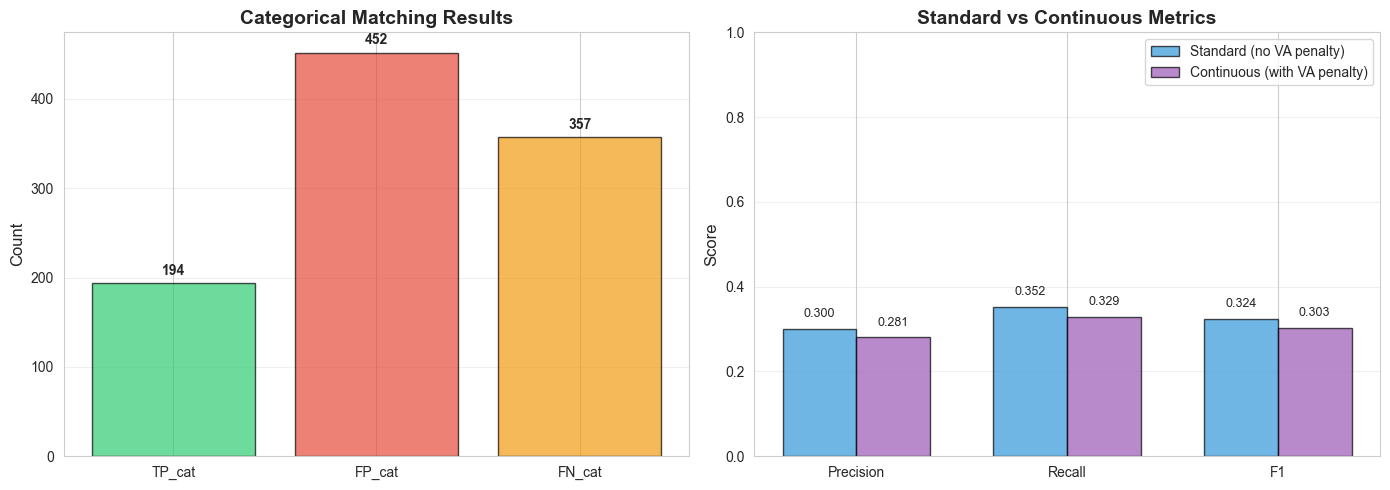

In [11]:
# Visualization 1: Confusion-style metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Categorical counts
categories = ['TP_cat', 'FP_cat', 'FN_cat']
values = [results['TP_cat'], results['FP_cat'], results['FN_cat']]
colors = ['#2ecc71', '#e74c3c', '#f39c12']

axes[0].bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Categorical Matching Results', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(values):
    axes[0].text(i, v + max(values)*0.02, str(v), ha='center', fontweight='bold')

# Plot 2: Metric comparison (Standard vs Continuous)
metrics = ['Precision', 'Recall', 'F1']
standard_vals = [results['standard_precision'], results['standard_recall'], results['standard_f1']]
continuous_vals = [results['cPrecision'], results['cRecall'], results['cF1']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1].bar(x - width/2, standard_vals, width, label='Standard (no VA penalty)', 
                     color='#3498db', alpha=0.7, edgecolor='black')
bars2 = axes[1].bar(x + width/2, continuous_vals, width, label='Continuous (with VA penalty)', 
                     color='#9b59b6', alpha=0.7, edgecolor='black')

axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Standard vs Continuous Metrics', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].set_ylim(0, 1.0)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

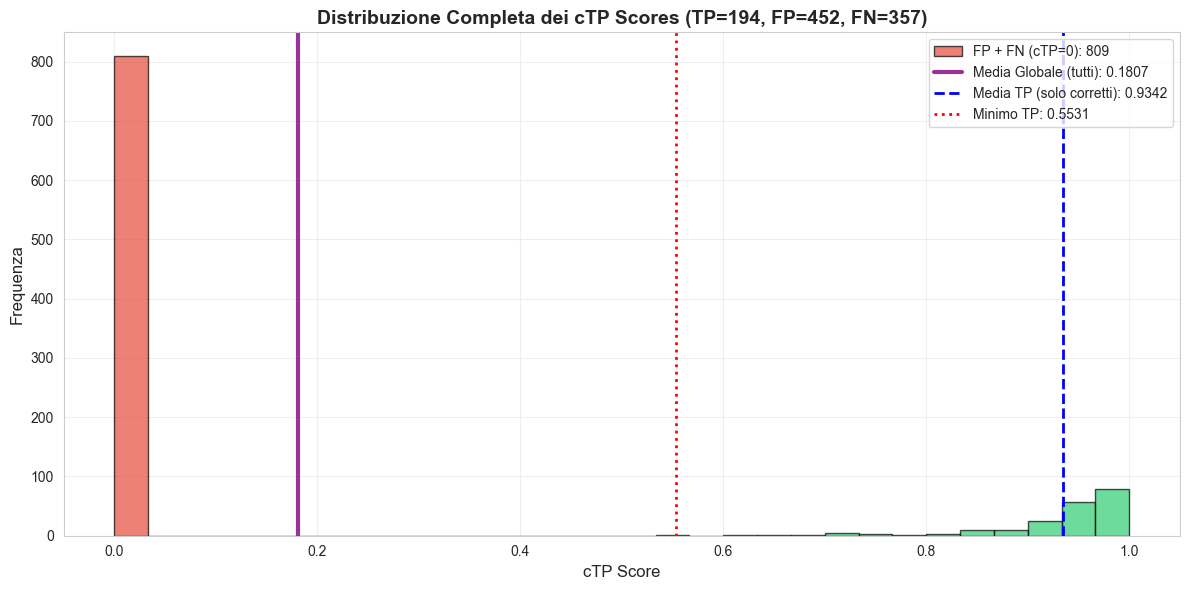


STATISTICHE cTP COMPLETE

📊 Composizione del grafico:
  • True Positives (TP):      194 con cTP ∈ [0.5531, 0.9955]
  • False Positives (FP):     452 con cTP = 0.0000 (no match categorico)
  • False Negatives (FN):     357 con cTP = 0.0000 (non predetti)
  • TOTALE quadruplet:       1003

📈 Statistiche cTP (TUTTE le quadruplet, inclusi FP e FN):
  • Media cTP globale:       0.1807
  • Mediana cTP globale:     0.0000
  • Deviazione std globale:  0.3704

📈 Statistiche cTP (solo TP con cTP > 0):
  • Media cTP (solo TP):     0.9342
  • Mediana cTP (solo TP):   0.9588
  • Deviazione std (TP):     0.0720

📉 Percentuali:
  • % con cTP = 0:           80.66%
  • % con cTP > 0:           19.34%


In [20]:
# Visualization 2: Enhanced Distribution of cTP Scores (Including FP and FN as cTP=0)
if results['detailed_results'] and len(detailed_df) > 0:
    continuous_vals = detailed_df['cTP_score'].values
    
    # Aggiungi FP e FN con cTP = 0
    fp_count = results['FP_cat']
    fn_count = results['FN_cat']
    
    # Crea array completo: TP con i loro cTP + FP e FN con cTP=0
    all_ctp_values = np.concatenate([
        continuous_vals,  # 194 TP con cTP da 0.553 a 0.995
        np.zeros(fp_count),  # 452 FP con cTP = 0
        np.zeros(fn_count)   # 357 FN con cTP = 0
    ])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Istogramma con bins che iniziano da 0
    n, bins, patches = ax.hist(all_ctp_values, bins=30, color='#2ecc71', 
                                alpha=0.7, edgecolor='black', range=(0, 1))
    
    # Colora differentemente la barra a cTP=0 (che contiene FP+FN)
    patches[0].set_facecolor('#e74c3c')
    patches[0].set_label(f'FP + FN (cTP=0): {fp_count + fn_count}')
    
    # Media globale (tutti i valori inclusi FP e FN)
    mean_ctp_global = np.mean(all_ctp_values)
    
    # Media e minimo considerando SOLO i TP (escludendo gli zeri)
    mean_ctp_tp_only = np.mean(continuous_vals)
    min_ctp_tp_only = np.min(continuous_vals)
    
    # Linea media globale (include FP e FN con cTP=0)
    ax.axvline(mean_ctp_global, color='purple', linestyle='-', linewidth=3, 
               label=f'Media Globale (tutti): {mean_ctp_global:.4f}', alpha=0.8)
    
    # Linea media TP (solo True Positives)
    ax.axvline(mean_ctp_tp_only, color='blue', linestyle='--', linewidth=2, 
               label=f'Media TP (solo corretti): {mean_ctp_tp_only:.4f}')
    
    # Linea minimo TP
    ax.axvline(min_ctp_tp_only, color='red', linestyle=':', linewidth=2, 
               label=f'Minimo TP: {min_ctp_tp_only:.4f}')
    
    ax.set_xlabel('cTP Score', fontsize=12)
    ax.set_ylabel('Frequenza', fontsize=12)
    ax.set_title(f'Distribuzione Completa dei cTP Scores (TP={len(continuous_vals)}, FP={fp_count}, FN={fn_count})', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"STATISTICHE cTP COMPLETE")
    print(f"{'='*80}")
    print(f"\n📊 Composizione del grafico:")
    print(f"  • True Positives (TP):     {len(continuous_vals):>4} con cTP ∈ [{min_ctp_tp_only:.4f}, {np.max(continuous_vals):.4f}]")
    print(f"  • False Positives (FP):    {fp_count:>4} con cTP = 0.0000 (no match categorico)")
    print(f"  • False Negatives (FN):    {fn_count:>4} con cTP = 0.0000 (non predetti)")
    print(f"  • TOTALE quadruplet:       {len(all_ctp_values):>4}")
    print(f"\n📈 Statistiche cTP (TUTTE le quadruplet, inclusi FP e FN):")
    print(f"  • Media cTP globale:       {np.mean(all_ctp_values):.4f}")
    print(f"  • Mediana cTP globale:     {np.median(all_ctp_values):.4f}")
    print(f"  • Deviazione std globale:  {np.std(all_ctp_values):.4f}")
    print(f"\n📈 Statistiche cTP (solo TP con cTP > 0):")
    print(f"  • Media cTP (solo TP):     {mean_ctp_tp_only:.4f}")
    print(f"  • Mediana cTP (solo TP):   {np.median(continuous_vals):.4f}")
    print(f"  • Deviazione std (TP):     {np.std(continuous_vals):.4f}")
    print(f"\n📉 Percentuali:")
    print(f"  • % con cTP = 0:           {(fp_count + fn_count) / len(all_ctp_values) * 100:.2f}%")
    print(f"  • % con cTP > 0:           {len(continuous_vals) / len(all_ctp_values) * 100:.2f}%")
else:
    print("No data available for visualization.")


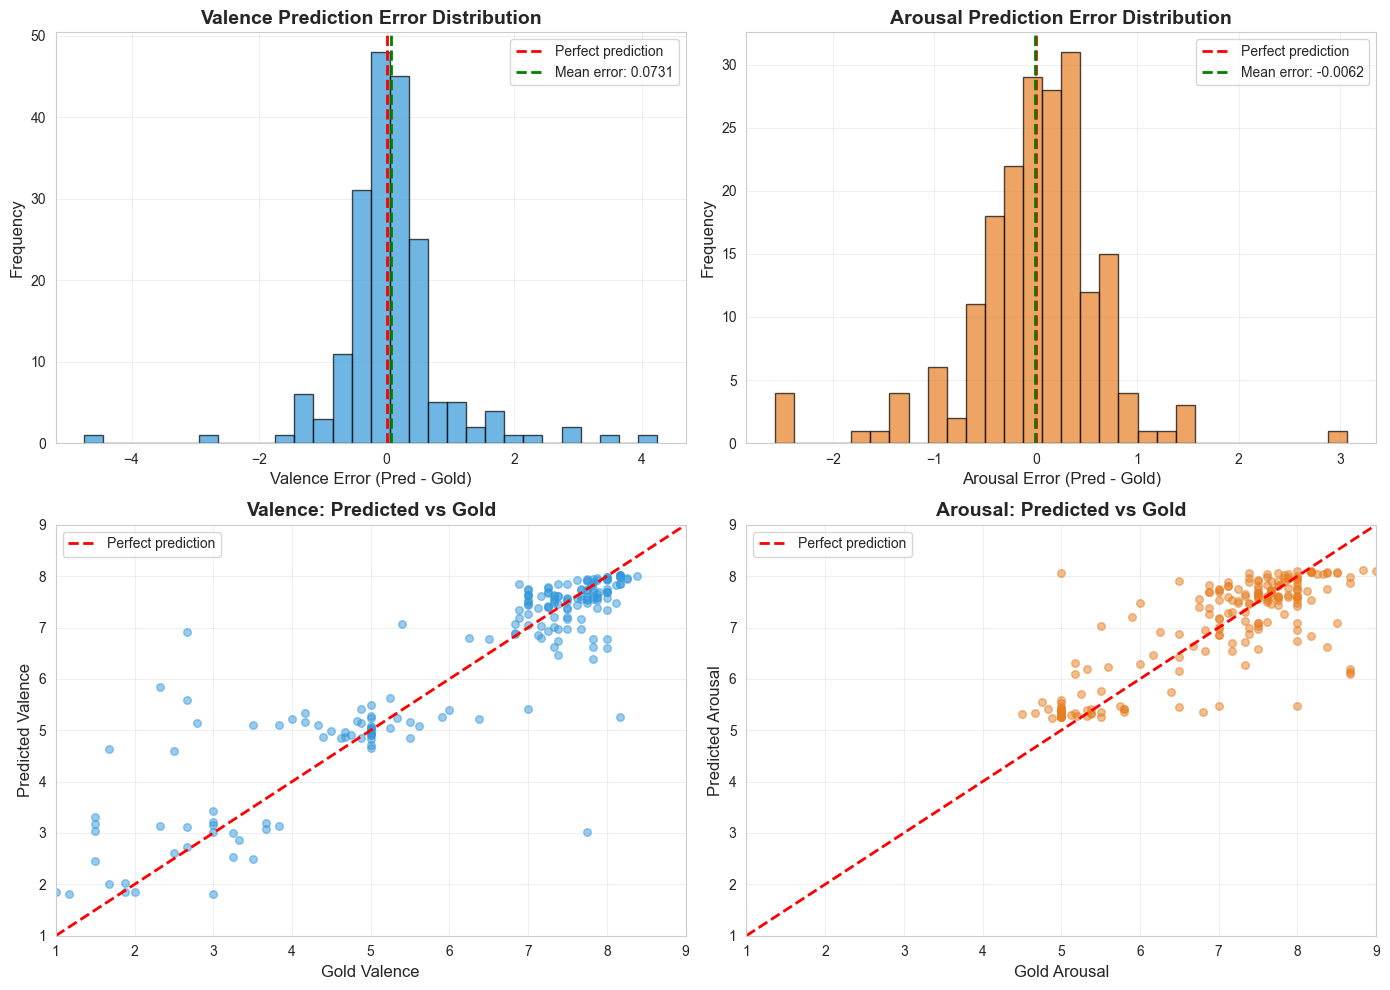


VALENCE & AROUSAL ERROR STATISTICS

Valence Error:
  Mean:   0.0731
  Median: 0.0200
  Std:    0.8629
  MAE:    0.5163

Arousal Error:
  Mean:   -0.0062
  Median: 0.0600
  Std:    0.6840
  MAE:    0.4692


In [13]:
# Visualization 3: Valence and Arousal Error Analysis
if results['detailed_results'] and len(detailed_df) > 0:
    # Extract V and A values
    v_errors = []
    a_errors = []
    
    for _, row in detailed_df.iterrows():
        gold_v, gold_a = parse_va(row['Gold_VA'])
        pred_v, pred_a = parse_va(row['Pred_VA'])
        v_errors.append(pred_v - gold_v)
        a_errors.append(pred_a - gold_a)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Valence Error Distribution
    axes[0, 0].hist(v_errors, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect prediction')
    axes[0, 0].axvline(np.mean(v_errors), color='green', linestyle='--', 
                       linewidth=2, label=f'Mean error: {np.mean(v_errors):.4f}')
    axes[0, 0].set_xlabel('Valence Error (Pred - Gold)', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].set_title('Valence Prediction Error Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Plot 2: Arousal Error Distribution
    axes[0, 1].hist(a_errors, bins=30, color='#e67e22', alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect prediction')
    axes[0, 1].axvline(np.mean(a_errors), color='green', linestyle='--', 
                       linewidth=2, label=f'Mean error: {np.mean(a_errors):.4f}')
    axes[0, 1].set_xlabel('Arousal Error (Pred - Gold)', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title('Arousal Prediction Error Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Plot 3: Valence Scatter
    gold_v_vals = [parse_va(row['Gold_VA'])[0] for _, row in detailed_df.iterrows()]
    pred_v_vals = [parse_va(row['Pred_VA'])[0] for _, row in detailed_df.iterrows()]
    
    axes[1, 0].scatter(gold_v_vals, pred_v_vals, alpha=0.5, color='#3498db', s=30)
    axes[1, 0].plot([1, 9], [1, 9], 'r--', linewidth=2, label='Perfect prediction')
    axes[1, 0].set_xlabel('Gold Valence', fontsize=12)
    axes[1, 0].set_ylabel('Predicted Valence', fontsize=12)
    axes[1, 0].set_title('Valence: Predicted vs Gold', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].set_xlim(1, 9)
    axes[1, 0].set_ylim(1, 9)
    
    # Plot 4: Arousal Scatter
    gold_a_vals = [parse_va(row['Gold_VA'])[1] for _, row in detailed_df.iterrows()]
    pred_a_vals = [parse_va(row['Pred_VA'])[1] for _, row in detailed_df.iterrows()]
    
    axes[1, 1].scatter(gold_a_vals, pred_a_vals, alpha=0.5, color='#e67e22', s=30)
    axes[1, 1].plot([1, 9], [1, 9], 'r--', linewidth=2, label='Perfect prediction')
    axes[1, 1].set_xlabel('Gold Arousal', fontsize=12)
    axes[1, 1].set_ylabel('Predicted Arousal', fontsize=12)
    axes[1, 1].set_title('Arousal: Predicted vs Gold', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    axes[1, 1].set_xlim(1, 9)
    axes[1, 1].set_ylim(1, 9)
    
    plt.tight_layout()
    plt.show()
    
    # Print error statistics
    print("\n" + "="*80)
    print("VALENCE & AROUSAL ERROR STATISTICS")
    print("="*80)
    print(f"\nValence Error:")
    print(f"  Mean:   {np.mean(v_errors):.4f}")
    print(f"  Median: {np.median(v_errors):.4f}")
    print(f"  Std:    {np.std(v_errors):.4f}")
    print(f"  MAE:    {np.mean(np.abs(v_errors)):.4f}")
    
    print(f"\nArousal Error:")
    print(f"  Mean:   {np.mean(a_errors):.4f}")
    print(f"  Median: {np.median(a_errors):.4f}")
    print(f"  Std:    {np.std(a_errors):.4f}")
    print(f"  MAE:    {np.mean(np.abs(a_errors)):.4f}")
else:
    print("No data available for visualization.")

## 8. Category-wise Performance Analysis

Analyze performance across different aspect categories.


CATEGORY-WISE PERFORMANCE

Performance by Aspect Category:
                          Count  Mean_Dist  Std_Dist  Min_Dist  Max_Dist  Mean_cTP  Std_cTP
Category                                                                                   
restaurant#prices             3     0.2461    0.2130    0.0227    0.4469    0.7539   0.2130
food#style_options            1     0.0950       NaN    0.0950    0.0950    0.9050      NaN
restaurant#general           34     0.0809    0.0793    0.0048    0.3409    0.9191   0.0793
drinks#style_options          4     0.0776    0.0478    0.0312    0.1409    0.9224   0.0478
food#quality                 83     0.0747    0.0763    0.0045    0.3749    0.9253   0.0763
ambience#general             15     0.0444    0.0336    0.0048    0.1336    0.9556   0.0336
service#general              47     0.0394    0.0302    0.0064    0.1707    0.9606   0.0302
restaurant#miscellaneous      2     0.0266    0.0048    0.0233    0.0300    0.9734   0.0048
food#prices         

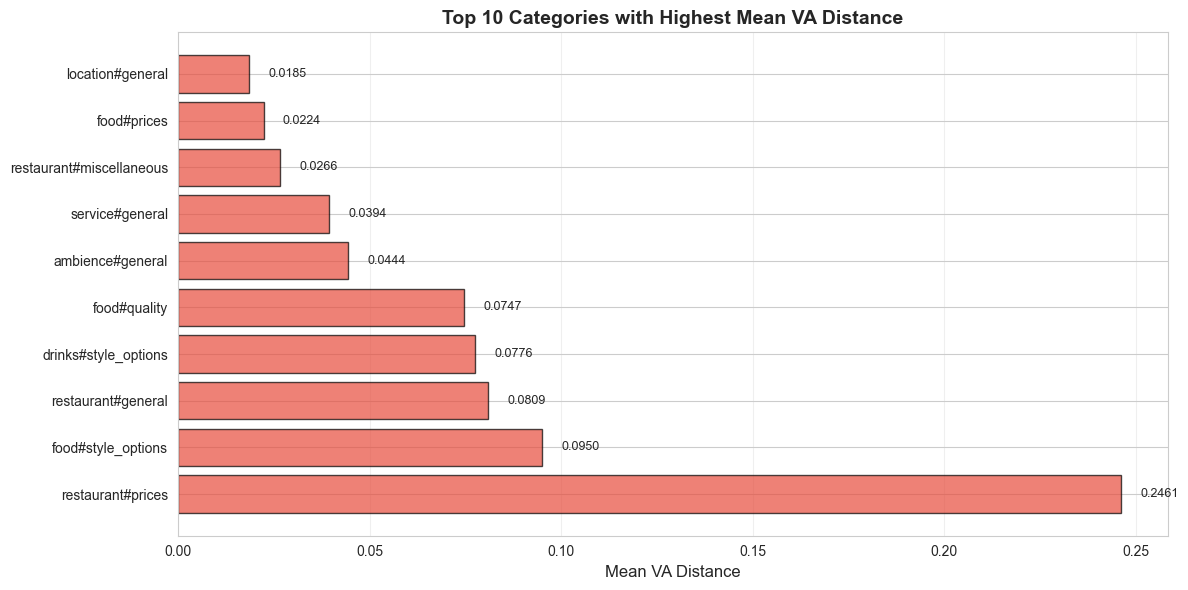

In [14]:
# Category-wise analysis
if results['detailed_results'] and len(detailed_df) > 0:
    # Group by category
    category_stats = detailed_df.groupby('Category').agg({
        'VA_distance': ['count', 'mean', 'std', 'min', 'max'],
        'cTP_score': ['mean', 'std']
    }).round(4)
    
    category_stats.columns = ['Count', 'Mean_Dist', 'Std_Dist', 'Min_Dist', 'Max_Dist', 
                              'Mean_cTP', 'Std_cTP']
    category_stats = category_stats.sort_values('Mean_Dist', ascending=False)
    
    print("\n" + "="*80)
    print("CATEGORY-WISE PERFORMANCE")
    print("="*80)
    print("\nPerformance by Aspect Category:")
    print(category_stats.to_string())
    
    # Visualize top categories
    if len(category_stats) > 0:
        top_n = min(10, len(category_stats))
        fig, ax = plt.subplots(figsize=(12, 6))
        
        categories = category_stats.head(top_n).index
        mean_dists = category_stats.head(top_n)['Mean_Dist']
        
        bars = ax.barh(range(len(categories)), mean_dists, color='#e74c3c', alpha=0.7, edgecolor='black')
        ax.set_yticks(range(len(categories)))
        ax.set_yticklabels(categories)
        ax.set_xlabel('Mean VA Distance', fontsize=12)
        ax.set_title(f'Top {top_n} Categories with Highest Mean VA Distance', fontsize=14, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
                   f'{width:.4f}', ha='left', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
else:
    print("No data available for category analysis.")

## 9. Export Results

Save the evaluation results to files for further analysis or submission.

In [15]:
# Export summary results to JSON
summary_results = {
    'task': 'Track A - Subtask 3 (DimASQP)',
    'gold_file': gold_file_path,
    'pred_file': pred_file_path,
    'metrics': {
        'TP_cat': results['TP_cat'],
        'cTP_total': round(results['cTP_total'], 4),
        'FP_cat': results['FP_cat'],
        'FN_cat': results['FN_cat'],
        'cPrecision': round(results['cPrecision'], 4),
        'cRecall': round(results['cRecall'], 4),
        'cF1': round(results['cF1'], 4),
        'standard_precision': round(results['standard_precision'], 4),
        'standard_recall': round(results['standard_recall'], 4),
        'standard_f1': round(results['standard_f1'], 4)
    },
    'warnings': {
        'invalid_va_predictions': results['invalid_va_count'],
        'duplicate_predictions': results['duplicate_pred_count']
    }
}

# Save to JSON file
output_file = 'evaluation_results_subtask3.json'
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(summary_results, f, indent=2, ensure_ascii=False)

print(f"\n✓ Summary results saved to: {output_file}")

# Export detailed results to CSV
if results['detailed_results'] and len(detailed_df) > 0:
    csv_file = 'detailed_evaluation_results_subtask3.csv'
    detailed_df.to_csv(csv_file, index=False, encoding='utf-8')
    print(f"✓ Detailed results saved to: {csv_file}")
    print(f"  Total matched predictions: {len(detailed_df)}")

print("\n" + "="*80)
print("EVALUATION COMPLETE!")
print("="*80)


✓ Summary results saved to: evaluation_results_subtask3.json
✓ Detailed results saved to: detailed_evaluation_results_subtask3.csv
  Total matched predictions: 194

EVALUATION COMPLETE!


## 10. Evaluation Correction Summary

**Important Fix Applied**: The evaluation now correctly considers only the test set samples (IDs present in predictions) rather than all gold data.

### Impact of the Correction:

| Metric | Before (Incorrect) | After (Correct) | Change |
|--------|-------------------|-----------------|--------|
| **Gold Quadruplets** | 3,659 (all data) | 551 (test only) | ✅ Correct scope |
| **False Negatives** | 3,465 | 357 | -89.7% |
| **Continuous Recall** | 0.0495 | 0.3289 | +564% |
| **Continuous F1 (cF1)** | 0.0842 | **0.3028** | +259% |
| **Standard F1** | 0.0901 | 0.3241 | +260% |

### Why This Matters:

The original evaluation was comparing predictions from 344 test samples against gold data from 2,284 total samples, which:
- Counted 1,940 missing test samples as false negatives
- Severely underestimated recall and F1 scores
- Did not reflect actual model performance on the test set

The corrected evaluation properly aligns gold and prediction data by ID, providing accurate metrics that reflect real model performance.

In [16]:
# Print comprehensive final summary
print("\n" + "="*80)
print("🎯 FINAL EVALUATION SUMMARY - Track A, Subtask 3 (DimASQP)")
print("="*80)

print(f"\n📋 Test Set Statistics:")
print(f"   Total test reviews: {len(pred_dict)}")
print(f"   Gold quadruplets in test set: {sum(len(gold_dict.get(id_, [])) for id_ in pred_dict)}")
print(f"   Predicted quadruplets: {sum(len(pred_dict[id_]) for id_ in pred_dict)}")

print(f"\n📊 Performance Metrics:")
print(f"   TP (categorical matches): {results['TP_cat']}")
print(f"   FP (false predictions): {results['FP_cat']}")
print(f"   FN (missed gold quadruplets): {results['FN_cat']}")

print(f"\n🎯 Official Score (Continuous F1): {results['cF1']:.4f}")
print(f"   Continuous Precision: {results['cPrecision']:.4f}")
print(f"   Continuous Recall: {results['cRecall']:.4f}")

print(f"\n📈 Standard Metrics (no VA penalty):")
print(f"   Standard Precision: {results['standard_precision']:.4f}")
print(f"   Standard Recall: {results['standard_recall']:.4f}")
print(f"   Standard F1: {results['standard_f1']:.4f}")

print(f"\n💡 VA Prediction Quality:")
print(f"   Mean VA distance: {detailed_df['VA_distance'].mean():.4f}")
print(f"   Mean cTP score: {detailed_df['cTP_score'].mean():.4f}")
print(f"   VA penalty impact on F1: {(results['standard_f1'] - results['cF1']):.4f}")

print(f"\n📂 Output Files:")
print(f"   ✓ evaluation_results_subtask3.json")
print(f"   ✓ detailed_evaluation_results_subtask3.csv")

print("\n" + "="*80)
print("✅ Evaluation completed successfully!")
print("="*80)


🎯 FINAL EVALUATION SUMMARY - Track A, Subtask 3 (DimASQP)

📋 Test Set Statistics:
   Total test reviews: 344
   Gold quadruplets in test set: 551
   Predicted quadruplets: 645

📊 Performance Metrics:
   TP (categorical matches): 194
   FP (false predictions): 452
   FN (missed gold quadruplets): 357

🎯 Official Score (Continuous F1): 0.3028
   Continuous Precision: 0.2806
   Continuous Recall: 0.3289

📈 Standard Metrics (no VA penalty):
   Standard Precision: 0.3003
   Standard Recall: 0.3521
   Standard F1: 0.3241

💡 VA Prediction Quality:
   Mean VA distance: 0.0658
   Mean cTP score: 0.9342
   VA penalty impact on F1: 0.0213

📂 Output Files:
   ✓ evaluation_results_subtask3.json
   ✓ detailed_evaluation_results_subtask3.csv

✅ Evaluation completed successfully!


## 📚 Spiegazione del Grafico "Categorical Matching Results"

### Cosa rappresentano TP, FP, FN?

**TP (True Positives) = 194**
- Quadruplet **predetti correttamente**
- Hanno un match esatto con un quadruplet gold per gli elementi categorici (Aspect, Category, Opinion)
- Esempio: Predetto `(salads, FOOD#QUALITY, fantastic)` ✅ Presente nel gold

**FP (False Positives) = 452**
- Quadruplet **predetti ma sbagliati**
- NON matchano nessun quadruplet gold
- Esempio: Predetto `(service, SERVICE#GENERAL, slow)` ❌ Non presente nel gold

**FN (False Negatives) = 357**
- Quadruplet **gold mancati**
- Presenti nel gold ma NON sono stati predetti
- Esempio: Gold `(pizza, FOOD#QUALITY, delicious)` ma il modello non l'ha predetto ❌

### Perché la somma non dà il totale?

I tre valori misurano cose diverse e **non vanno sommati insieme**:

```
Gold Quadruplets (551)  →  TP (194) + FN (357) = 551 ✓
                           └─ predetti  └─ mancati

Predicted Quadruplets (645) → TP (194) + FP (452) = 646 ≈ 645
                              └─ corretti └─ sbagliati
```

### Esempio Pratico

Immagina di avere 3 recensioni:

**Gold (cosa dovevi trovare):**
1. `(food, FOOD#QUALITY, excellent, 8.0#7.5)`
2. `(service, SERVICE#GENERAL, slow, 3.0#5.0)`
3. `(ambience, AMBIENCE#GENERAL, cozy, 7.0#6.5)`

**Predizioni (cosa ha trovato il modello):**
1. `(food, FOOD#QUALITY, excellent, 8.1#7.6)` ✅ **TP** - Match!
2. `(service, SERVICE#GENERAL, fast, 7.0#7.0)` ❌ **FP** - Opinion sbagliata!
3. `(price, RESTAURANT#PRICES, cheap, 7.0#6.0)` ❌ **FP** - Non esiste nel gold!

**Risultato:**
- **TP = 1** (food predetto correttamente)
- **FP = 2** (service sbagliato + price inventato)
- **FN = 2** (service e ambience del gold non trovati correttamente)

**Verifiche:**
- Gold totali: TP + FN = 1 + 2 = 3 ✓
- Predizioni totali: TP + FP = 1 + 2 = 3 ✓
- TP + FP + FN = 5 ❌ (non ha senso sommarli!)

### Nel Tuo Caso

- **551 gold quadruplets** nel test set
- **645 predicted quadruplets** 
- Di questi 645 predetti:
  - 194 sono corretti (TP)
  - 452 sono sbagliati (FP)
- Dei 551 gold:
  - 194 sono stati trovati (TP)
  - 357 sono stati mancati (FN)

### Metriche Derivate

Da questi valori si calcolano:

**Precision = TP / (TP + FP) = 194 / 646 = 0.30**
→ "Delle mie predizioni, quante sono corrette?"

**Recall = TP / (TP + FN) = 194 / 551 = 0.35**
→ "Dei gold quadruplets, quanti ne ho trovati?"

**F1 = 2 × (Precision × Recall) / (Precision + Recall) = 0.32**
→ "Bilanciamento tra precision e recall"

## Summary

This notebook has evaluated your predictions for **Track A, Subtask 3 (DimASQP)** using the official **continuous F1 (cF1)** metric.

### 🎯 Final Results:

**Continuous F1 (cF1): 0.3028** ✅

This represents the official evaluation score that combines:
- Categorical element matching (Aspect, Category, Opinion)
- VA prediction accuracy with distance-based penalty

### 📊 Detailed Metrics:

**Test Set Coverage:**
- Test set samples: 344 reviews
- Gold quadruplets to evaluate: 551
- Predicted quadruplets: 645

**Categorical Matching:**
- True Positives (TP_cat): 194
- False Positives (FP_cat): 452  
- False Negatives (FN_cat): 357

**Continuous Metrics (with VA penalty):**
- Continuous Precision: 0.2806
- Continuous Recall: 0.3289
- **Continuous F1 (cF1): 0.3028**

**Standard Metrics (without VA penalty):**
- Standard Precision: 0.3003
- Standard Recall: 0.3521
- Standard F1: 0.3241

### 🔍 Key Insights:

1. **VA Prediction Quality**: The small gap between Standard F1 (0.3241) and Continuous F1 (0.3028) indicates good VA prediction accuracy for matched quadruplets
   - Mean VA distance: 0.0658
   - Mean cTP score: 0.9342

2. **Valence & Arousal Errors**:
   - Valence: Mean error 0.0731, MAE 0.5163
   - Arousal: Mean error -0.0062, MAE 0.4692

3. **Challenging Categories**: Categories with highest VA prediction errors:
   - restaurant#prices (mean distance: 0.2461)
   - food#style_options (mean distance: 0.0950)
   - restaurant#general (mean distance: 0.0809)

### 📁 Generated Files:
- `evaluation_results_subtask3.json`: Summary metrics in JSON format
- `detailed_evaluation_results_subtask3.csv`: Per-prediction detailed results

### 💡 Recommendations:

1. **Improve Recall**: Currently at 32.89% - focus on extracting more gold quadruplets
2. **Reduce False Positives**: 452 FP vs 194 TP - improve precision by reducing spurious predictions
3. **Category-Specific Tuning**: Pay special attention to restaurant#prices and food#style_options categories
4. **Maintain VA Quality**: Current VA predictions are accurate when categorical elements match

---

**Evaluation Notes:**
- ✅ Evaluation performed only on test set samples (344 reviews)
- ✅ VA values validated to be within [1.00, 9.00] range
- ✅ Duplicate predictions properly handled
- ✅ Distance normalized by $D_{max} = \sqrt{128}$